# Vehicle Classification Using Silhouette Features

**Objective:**
The purpose here is to classify a given silhouette as one of three types of vehicle, using a set of features extracted from the silhouette. The vehicle may be viewed from one of many different angles. We will use SVM classification with and without PCA on features to classify the vehicles.

**Overview of data:**
The data contains features extracted from the silhouette of vehicles in different angles. Four "Corgie" model vehicles were used for the experiment: a double decker bus, Cheverolet van, Saab 9000 and an Opel Manta 400 cars. This particular combination of vehicles was chosen with the expectation that the bus, van and either one of the cars would be readily distinguishable, but it would be more difficult to distinguish between the cars.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
df = pd.read_csv('vehicle-1.csv')

In [3]:
df.sample(10) # view sample data

compactness  circularity  distance_circularity  radius_ratio  \
6             97         43.0                  73.0         173.0   
179           89         44.0                  70.0         137.0   
800           88         41.0                  80.0         147.0   
160           82         38.0                  53.0         125.0   
487           93         45.0                  81.0         177.0   
202          111         54.0                 103.0         171.0   
578           92         46.0                  82.0         170.0   
762           90         44.0                  69.0         152.0   
590           84         44.0                  65.0         128.0   
135           89         47.0                  83.0         322.0   

     pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
6                    65.0                        6          153.0   
179                  58.0                        6          136.0   
800                  62.0                        8          146.0   
160                  59.0                        5          133.0   
487                  64.0                        7          160.0   
202                  50.0                       11          221.0   
578                  58.0                        8          165.0   
762                  64.0                        7          135.0   
590                  55.0                        8          150.0   
135                 133.0                       48          158.0   

     elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
6             42.0                    19.0                        143   
179           49.0                    18.0                        146   
800           45.0                    19.0                        144   
160           51.0                    18.0                        128   
487           41.0                    20.0                        147   
202           30.0                    25.0                        172   
578           40.0                    20.0                        149   
762           49.0                    18.0                        145   
590           46.0                    19.0                        148   
135           43.0                    20.0                        163   

     scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
6              176.0              361.0                      172.0   
179            168.0              273.0                      166.0   
800            169.0              318.0                      161.0   
160            152.0              259.0                      146.0   
487            180.0              383.0                      188.0   
202            227.0              727.0                      201.0   
578            181.0              409.0                      164.0   
762            165.0              272.0                      162.0   
590            169.0              325.0                      176.0   
135            229.0              364.0                      176.0   

     scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
6                           66.0            13.0               1.0   
179                         78.0            10.0               3.0   
800                         71.0             4.0              16.0   
160                         87.0             0.0               0.0   
487                         70.0            11.0              11.0   
202                         69.0            15.0               6.0   
578                         61.0             8.0              11.0   
762                         75.0             3.0               2.0   
590                         82.0             1.0              11.0   
135                         97.0             0.0              14.0   

     skewness_about.2  hollows_ratio class  
6               200.0            204   bus  
179             186.0            187   van  
800 

In [4]:
df.isnull().sum() # Check for missing values in data

compactness                    0
circularity                    5
distance_circularity           4
radius_ratio                   6
pr.axis_aspect_ratio           2
max.length_aspect_ratio        0
scatter_ratio                  1
elongatedness                  1
pr.axis_rectangularity         3
max.length_rectangularity      0
scaled_variance                3
scaled_variance.1              2
scaled_radius_of_gyration      2
scaled_radius_of_gyration.1    4
skewness_about                 6
skewness_about.1               1
skewness_about.2               1
hollows_ratio                  0
class                          0
dtype: int64

In [5]:
# There are missing values in most of the columns 

In [6]:
df.dtypes

compactness                      int64
circularity                    float64
distance_circularity           float64
radius_ratio                   float64
pr.axis_aspect_ratio           float64
max.length_aspect_ratio          int64
scatter_ratio                  float64
elongatedness                  float64
pr.axis_rectangularity         float64
max.length_rectangularity        int64
scaled_variance                float64
scaled_variance.1              float64
scaled_radius_of_gyration      float64
scaled_radius_of_gyration.1    float64
skewness_about                 float64
skewness_about.1               float64
skewness_about.2               float64
hollows_ratio                    int64
class                           object
dtype: object

In [7]:
# All the features are numerics.
# Missing values are only in float dataype columns

### Data pre-processing

In [8]:
# Since the geometrical features of the same category of vehicle is more likely to predict its own missing geometrical feature values.
# Hence, we will group the dataframe by class and use regression to find missing values. 

In [9]:
cat = df['class'].unique()
cat # independent classes 

array(['van', 'car', 'bus'], dtype=object)

In [10]:
cols = df.columns
cols.shape[0] # Number of features

19

In [11]:
# Label encoding 
from sklearn.preprocessing import LabelEncoder
en = LabelEncoder()
#df['class'] = en.fit_transform(cat)
df['class'] = en.fit_transform(df['class'])
print([0,1,2])
list(en.inverse_transform([0,1,2])) # check labels of categories

[0, 1, 2]


['bus', 'car', 'van']

In [12]:
g = df.groupby('class')

In [13]:
van = g.get_group(2)
van.reset_index(drop=True, inplace=True)

In [14]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [15]:
imp = IterativeImputer(max_iter=10, random_state=0)
van_train = van.dropna(axis='rows')
imp.fit(van_train)

IterativeImputer(random_state=0)

In [16]:
van_test = van[van.isnull().any(axis=1)]
van_imputed = pd.DataFrame(np.round(imp.transform(van_test)), columns = cols)
van_corr = pd.concat([van_train, van_imputed], ignore_index=True)

In [17]:
car = g.get_group(1)
car.reset_index(drop=True, inplace=True)

In [18]:
imp = IterativeImputer(max_iter=10, random_state=0)
car_train = car.dropna(axis='rows')
imp.fit(car_train)

IterativeImputer(random_state=0)

In [19]:
car_test = car[car.isnull().any(axis=1)]
car_imputed = pd.DataFrame(np.round(imp.transform(car_test)), columns = cols)
car_corr = pd.concat([car_train, car_imputed], ignore_index=True)

In [20]:
bus = g.get_group(0)
bus.reset_index(drop=True, inplace=True)

In [21]:
imp = IterativeImputer(max_iter=10, random_state=0)
bus_train = bus.dropna(axis='rows')
imp.fit(bus_train)

IterativeImputer(random_state=0)

In [22]:
bus_test = bus[bus.isnull().any(axis=1)]
bus_imputed = pd.DataFrame(np.round(imp.transform(bus_test)), columns = cols)
bus_corr = pd.concat([bus_train, bus_imputed], ignore_index=True)

In [23]:
# All missing values have now been imputed 

In [24]:
dups = df.duplicated() # Check for duplicate data points
print("Number of duplicate data:", dups.sum())

Number of duplicate data: 0


### Understanding the attributes

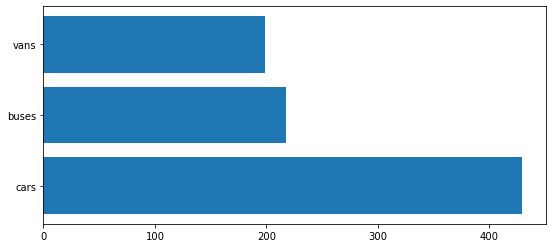

In [25]:
# Distribution of class in the the given data
n_car = car.shape[0]
n_bus = bus.shape[0]
n_van= van.shape[0]
plt.figure(figsize=(9,4))
_ = plt.barh(['cars','buses','vans'], [n_car, n_bus, n_van], )

In [26]:
df_n = pd.concat([bus_corr, car_corr, van_corr], ignore_index=True) # getting back the orginal dataframe 
df_n.describe().T

count        mean         std    min     25%  \
compactness                  846.0   93.678487    8.234474   73.0   87.00   
circularity                  846.0   44.862884    6.171522   33.0   40.00   
distance_circularity         846.0   82.094563   15.765982   40.0   70.00   
radius_ratio                 846.0  168.946809   33.469877  104.0  141.00   
pr.axis_aspect_ratio         846.0   61.693853    7.888101   47.0   57.00   
max.length_aspect_ratio      846.0    8.567376    4.601217    2.0    7.00   
scatter_ratio                846.0  168.839243   33.244978  112.0  146.25   
elongatedness                846.0   40.933806    7.811560   26.0   33.00   
pr.axis_rectangularity       846.0   20.582742    2.592138   17.0   19.00   
max.length_rectangularity    846.0  147.998818   14.515652  118.0  137.00   
scaled_variance              846.0  188.626478   31.401390  130.0  167.00   
scaled_variance.1            846.0  439.918440  176.698913  184.0  318.25   
scaled_radius_of_gyration    846.0  174.698582   32.547174  109.0  149.00   
scaled_radius_of_gyration.1  846.0   72.460993    7.481592   59.0   67.00   
skewness_about               846.0    6.359338    4.904624    0.0    2.00   
skewness_about.1             846.0   12.609929    8.933500    0.0    5.00   
skewness_about.2             846.0  188.930260    6.160082  176.0  184.00   
hollows_ratio                846.0  195.632388    7.438797  181.0  190.25   
class                        846.0    0.977541    0.702130    0.0    0.00   

                               50%    75%     max  
compactness                   93.0  100.0   119.0  
circularity                   44.0   49.0    59.0  
distance_circularity          80.0   98.0   112.0  
radius_ratio                 167.0  195.0   333.0  
pr.axis_aspect_ratio          61.0   65.0   138.0  
max.length_aspect_ratio        8.0   10.0    55.0  
scatter_ratio                157.0  198.0   265.0  
elongatedness                 43.0   46.0    61.0  
pr.axis_rectangularity        20.0   23.0    29.0  
max.length_rectangularity    146.0  159.0   188.0  
scaled_variance              178.5  217.0   320.0  
scaled_variance.1            364.0  587.0  1018.0  
scaled_radius_of_gyration    173.0  198.0   268.0  
scaled_radius_of_gyration.1   71.5   75.0   135.0  
skewness_about                 6.0    9.0    22.0  
skewness_about.1              11.0   19.0    41.0  
skewness_about.2             188.0  193.0   206.0  
hollows_ratio                197.0  201.0   211.0  
class                          1.0    1.0     2.0

In [27]:
# Most features seem normally distributed but some are skewed. For more information we will check the pairplot.

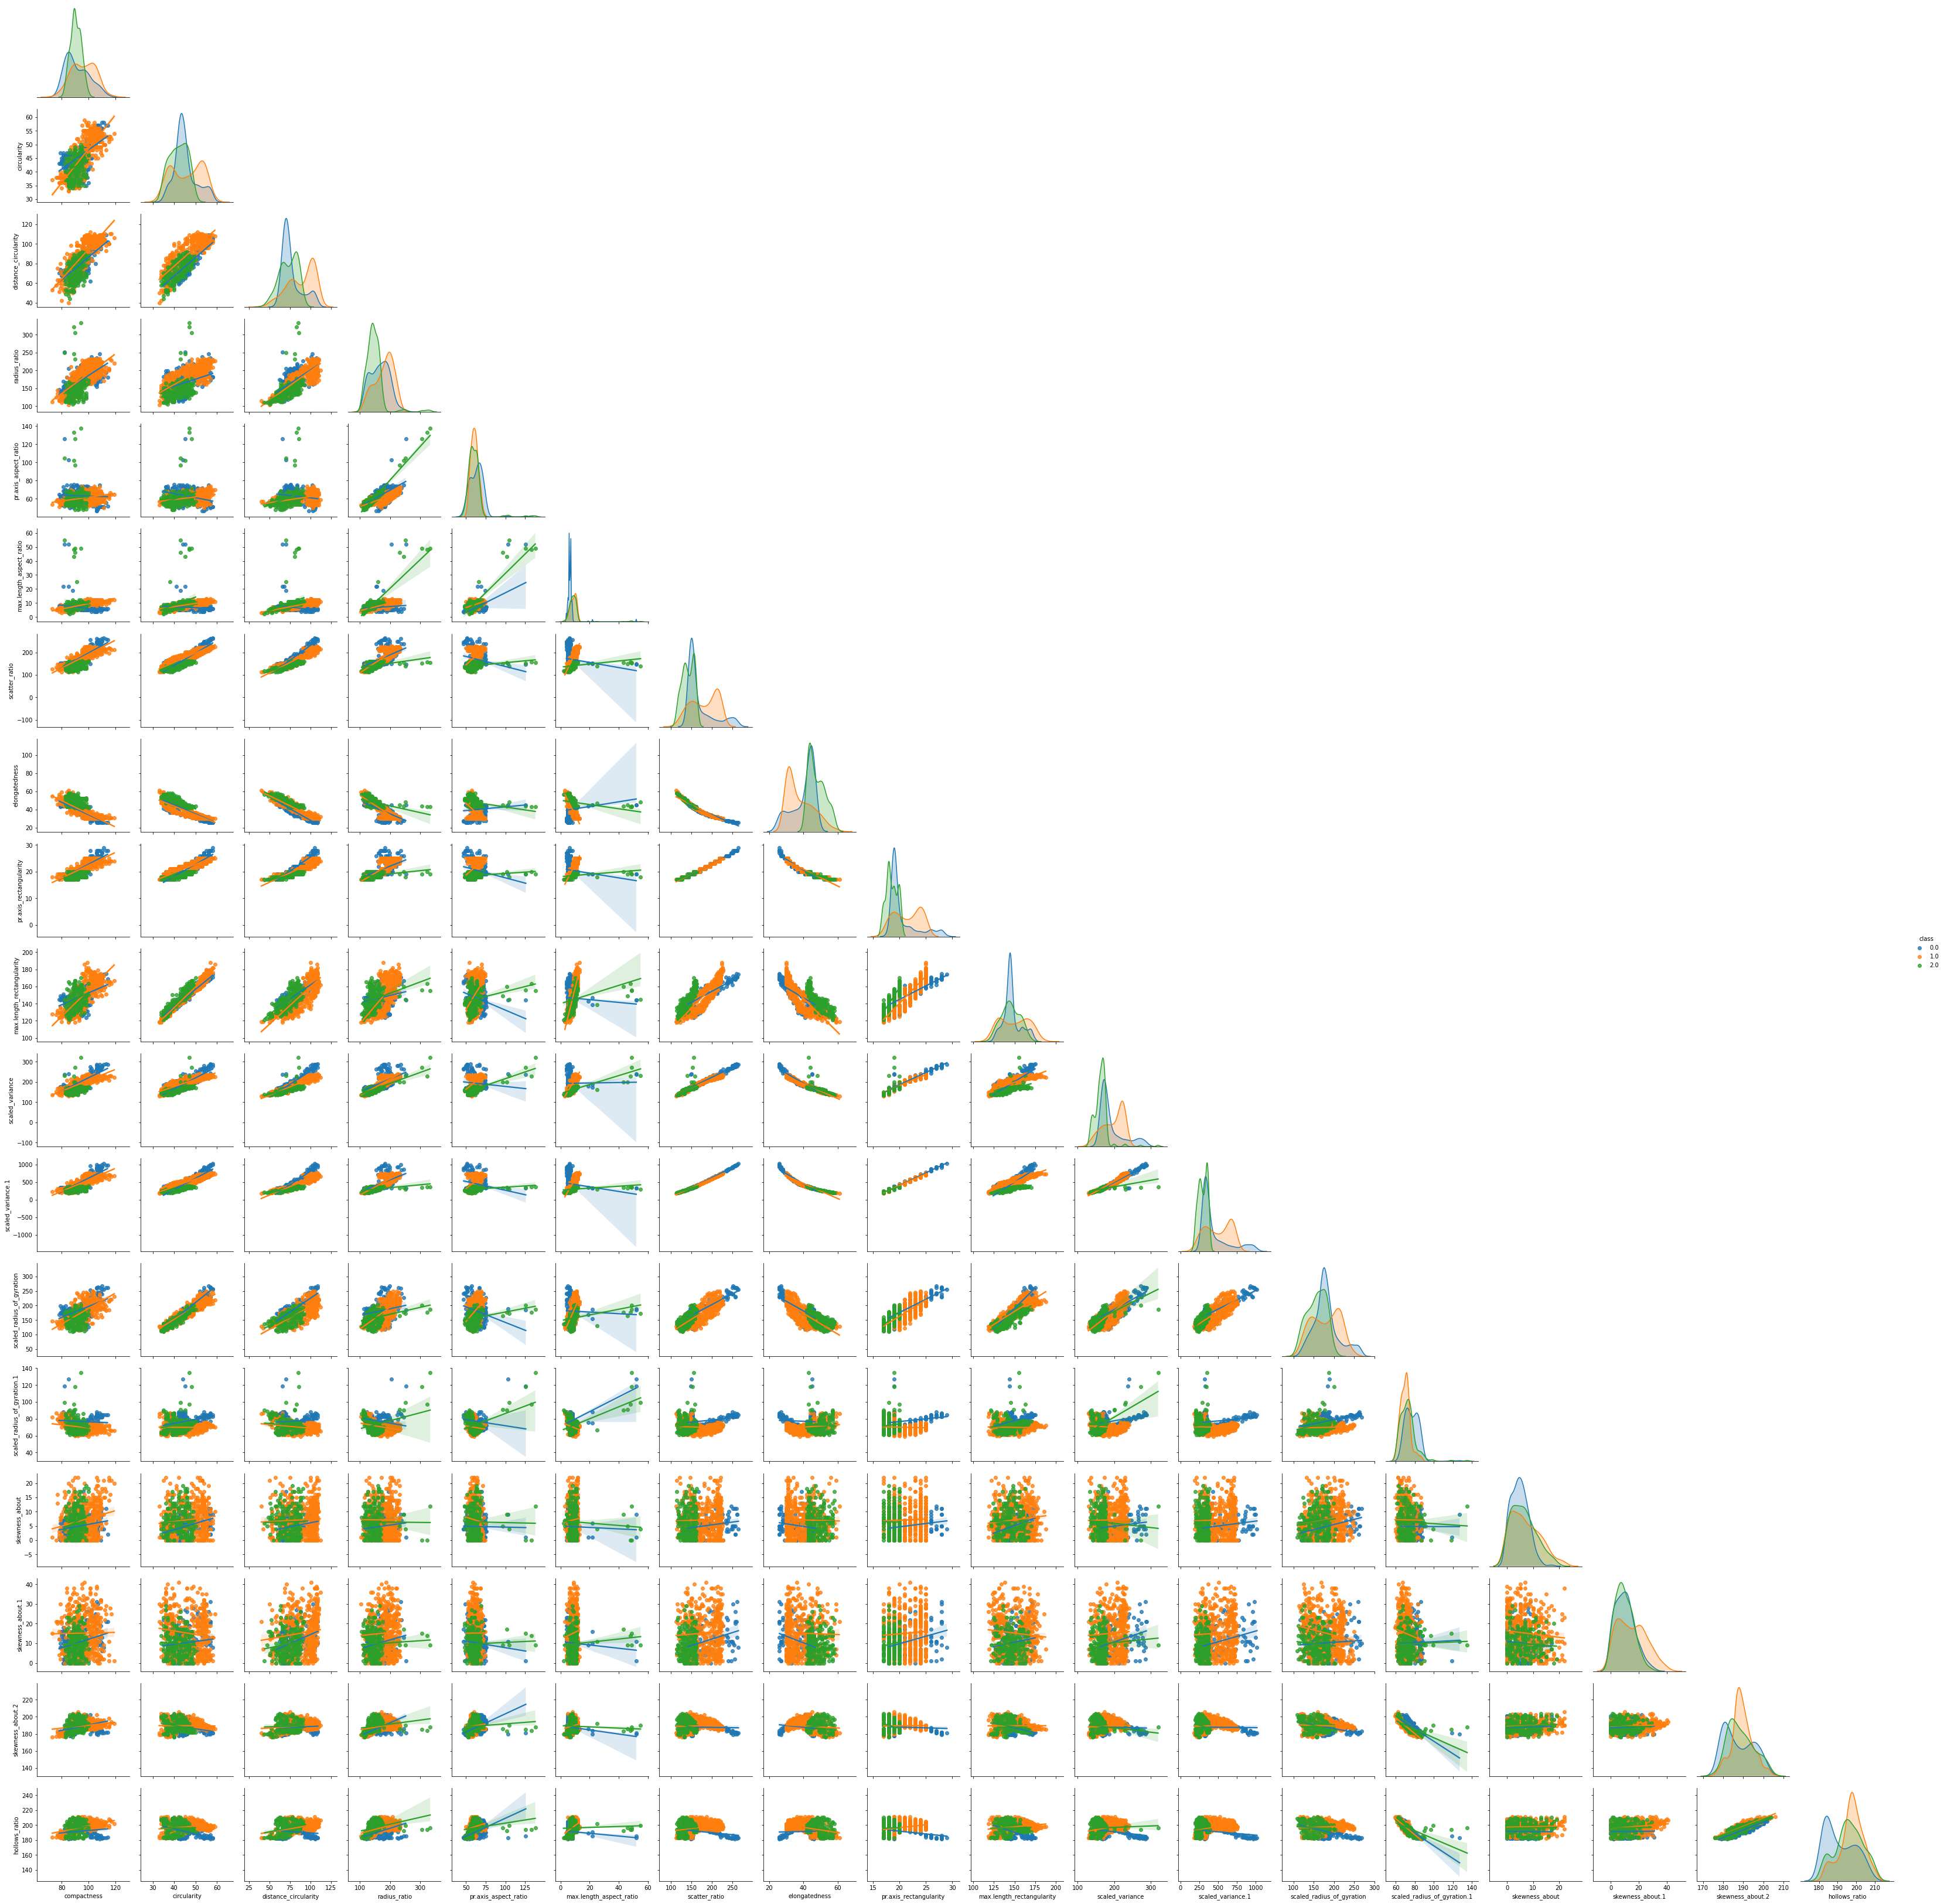

In [28]:
sns.pairplot(df_n, hue='class', corner=True, kind='reg')

#### Observations from pairplot
- skewness_about and skewness_about.1 are poor predictors of class.
- pr_axis_aspect_ratio is a very poor predictor of class, since there is much overlap between classes.
##### The following features have high collinearity:
    - circularity and distance_circularitry (0.80)
    - scatter_ratio and compactnes (0.81)
    - scatter ratio with circularity and distance_circularity (.86, 0.91)
    - scatter ratio and elongatedness (-0.97)
    - elongatedness and distance_circularity (0.91)
    - max.length_rectangularity and circularity (0.97)
    - scatter ratio and pr.axis_rectangularity (0.99) 
    - pr.axis_rectangularity with scaled_variance and scaled_variance.1 (0.94, 0.99)
    - scaled_radius_of_gyration with circularity (0.94)

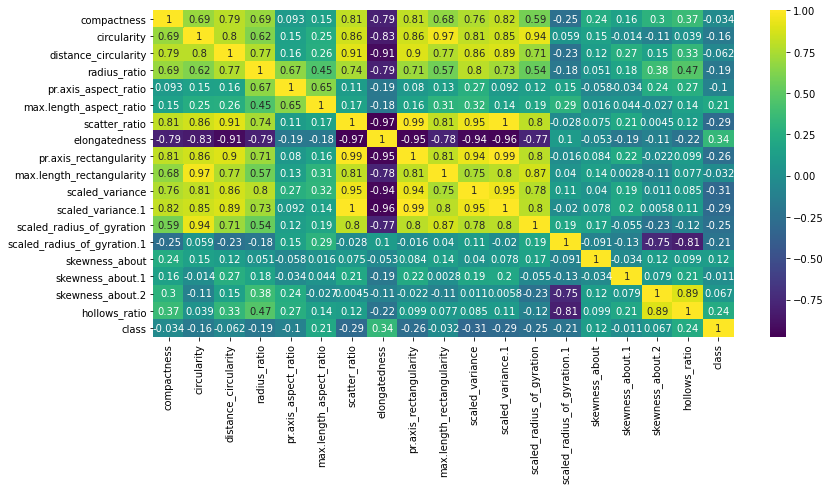

In [29]:
plt.figure(figsize=(13,6))
sns.heatmap(df_n.corr(), annot=True, cmap='viridis')

* RBF Kernel is based on distance between the data points, similar to K-Nearest Neighbors. If we have 5 features and one of the features is repeated multiple times, then the repeated feature will be contributing multiple times to the distance as any other feature, hence the model will be much more impacted by this feature. Hence, RBF kernel of Support Vector Machines is impacted by multicollinearity.

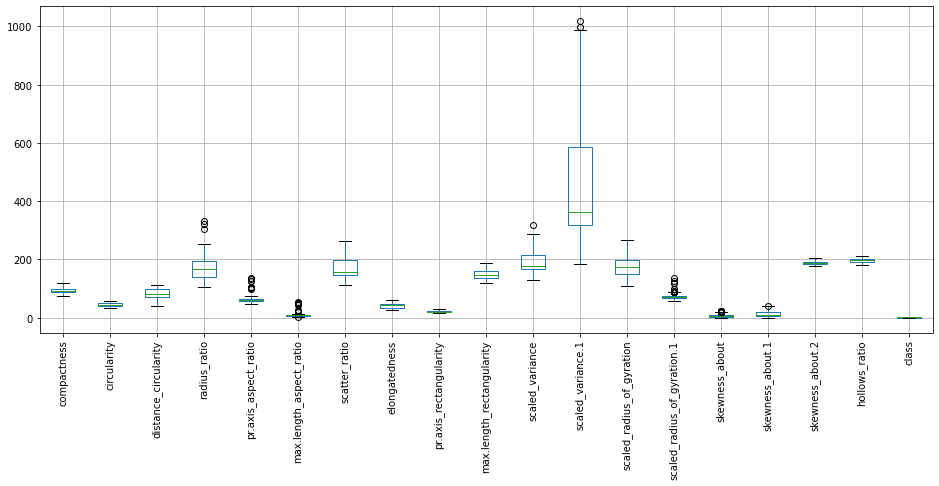

In [30]:
# Getting the outliers by using boxplot
df_n.boxplot(figsize = (16, 6), rot = 90)

* There are not many outliers in the data. Since SVM is not affected by outliers we shall not remove them.

In [31]:
df_pca = df_n.copy(deep=True) # creating a copy for pca later 

In [32]:
df_n.drop(['scatter_ratio', 'circularity', 'scaled_variance.1'], axis='columns', inplace=True)

* As observed from the correlations above dropping scatter ratio, circularity and scaled_variance.1 will remove much of muticollinearity

In [33]:
df_n.shape

(846, 16)

#### Splitting the data into train & test set, feature scaling

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
target = df_n['class']
features = df_n.drop('class', axis=1)
X_train, X_test, y_train, y_test = train_test_split(features,target, test_size = 0.2, random_state = 10, stratify = target)

In [36]:
target_pca =  df_pca['class']
features_pca = df_pca.drop('class', axis=1)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(features_pca, target_pca, test_size = 0.2, random_state = 10, stratify = target_pca)

In [37]:
from sklearn.preprocessing import StandardScaler

In [38]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [39]:
# scaling separately for all the attributes for doing PCA later
X_train_pca = sc.fit_transform(X_train_pca)
X_test_pca = sc.transform(X_test_pca)

In [40]:
accuracies = {}

#### Build SVM model

In [41]:
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score

In [42]:
svc = svm.SVC(C=1, kernel='linear', gamma=10)
svc.fit(X_train, y_train)

SVC(C=1, gamma=10, kernel='linear')

In [43]:
svc1_pred = svc.predict(X_test)

In [44]:
# check the accuracy on the training and test set
print('Training accuracy:', svc.score(X_train, y_train))
print('Test accuracy:', svc.score(X_test, y_test))
svm1_acc = svc.score(X_test, y_test)
accuracies['SVM_1'] = svm1_acc

Training accuracy: 0.9689349112426036
Test accuracy: 0.9588235294117647


In [45]:
# Finding best parameters for SVM using GridSearch

#params = {'C' : [0.01,0.05,0.1,0.5,1,2,3,5,10,50,100], 'kernel' :['linear','rbf'], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
params = [{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'kernel': ['linear']},
              {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'kernel': ['rbf'], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}]
grid_svm = GridSearchCV(svm.SVC(), param_grid = params, scoring = 'accuracy', cv = 5)

In [46]:
grid_svm.fit(X_train,y_train)
grid_svm.best_params_

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

In [47]:
# Build model using above parameters 
kernels = {'linear', 'rbf', 'poly', 'sigmoid'}
kernel_accuracies = []
for k in kernels:
    
    svc2 = svm.SVC(C=100, kernel=k, gamma=0.01)
    svc2.fit(X_train, y_train)
    svc2_pred = svc2.predict(X_test)
    
    # check the accuracy on the training and test set
    print('\n')
    print('Training accuracy using {} kernel: {}'.format(k , svc2.score(X_train, y_train)))
    print('Test accuracy using {} kernel: {}'.format(k , svc2.score(X_test, y_test)))
    
    svm2_acc = svc2.score(X_test, y_test)
    kernel_accuracies.append(svm2_acc)




Training accuracy using rbf kernel: 0.9911242603550295
Test accuracy using rbf kernel: 0.9764705882352941


Training accuracy using sigmoid kernel: 0.8846153846153846
Test accuracy using sigmoid kernel: 0.8352941176470589


Training accuracy using linear kernel: 0.9896449704142012
Test accuracy using linear kernel: 0.9411764705882353


Training accuracy using poly kernel: 0.7292899408284024
Test accuracy using poly kernel: 0.7352941176470589


In [48]:
# The best performance is obtained using the linear kernel. Hence retaining that
accuracies['SVM_2'] = max(kernel_accuracies)

#### Dimensionality reduction using PCA

In [49]:
# Create covariance matrix
cov_matrix = np.cov(X_train_pca.T)
print("Covariance Matrix", cov_matrix)

Covariance Matrix [[ 1.00148148  0.69570557  0.79018299  0.69378283  0.10291983  0.19212952
   0.81495551 -0.79289515  0.81480114  0.67958662  0.76934904  0.8204561
   0.59272102 -0.23877767  0.26103301  0.1625189   0.29893617  0.36159469]
 [ 0.69570557  1.00148148  0.79621421  0.61472484  0.14626167  0.27766674
   0.85727501 -0.82613226  0.85634204  0.96720581  0.80431921  0.84927305
   0.93721618  0.0825699   0.17471376 -0.02172378 -0.1250396   0.02080461]
 [ 0.79018299  0.79621421  1.00148148  0.76570594  0.16008323  0.30917515
   0.90524534 -0.9123898   0.89316723  0.77230253  0.86471485  0.88665406
   0.70892778 -0.21170134  0.13467396  0.26791225  0.13378438  0.31564883]
 [ 0.69378283  0.61472484  0.76570594  1.00148148  0.67128766  0.4822109
   0.73414629 -0.78671893  0.70678931  0.56609995  0.79432591  0.72156698
   0.53087441 -0.168483    0.05866862  0.18764466  0.36963055  0.45562978]
 [ 0.10291983  0.14626167  0.16008323  0.67128766  1.00148148  0.64984856
   0.10106687 -0.1

In [50]:
# Identify eigen values and eigen vector

eig_vals, eig_vecs = np.linalg.eig(cov_matrix)
print("eig_vals:", eig_vals)
print("eig_vecs:", eig_vecs)

eig_vals: [9.43820770e+00 3.06782205e+00 1.87114519e+00 1.21231012e+00
 8.65961604e-01 5.56432445e-01 3.42872951e-01 2.29155185e-01
 1.50800353e-01 8.96005496e-02 6.55403721e-02 4.26260136e-02
 3.66220067e-02 3.64394816e-04 6.51489212e-03 2.14077257e-02
 1.34161831e-02 1.58669294e-02]
eig_vecs: [[ 2.75703805e-01  1.30536823e-01 -1.21969499e-01 -8.26427798e-02
   5.95294140e-02  1.30091883e-01  4.36132841e-01 -5.60069188e-01
   5.03649202e-01  2.72845542e-01 -3.70304428e-02  2.03733296e-02
   1.63359015e-01 -9.51809844e-04 -6.12263785e-03 -4.41433799e-02
  -3.94265427e-02  2.76220589e-02]
 [ 2.94738064e-01 -1.28857625e-01 -2.57563553e-02 -1.80851616e-01
  -8.19518614e-02 -2.79458424e-01 -2.61184114e-01 -1.65542283e-01
   1.59501707e-02 -9.14668626e-02  9.35792797e-04 -1.05170633e-01
  -3.77964471e-02 -1.21740880e-02 -1.49820405e-01  1.83618602e-01
  -6.31605299e-01 -4.54283689e-01]
 [ 3.03591535e-01  7.55830846e-02 -5.55125276e-02  6.89350253e-02
   4.73293066e-02 -1.44038823e-01  7.757

In [51]:
tot = sum(eig_vals)
var_exp = [ (i/tot)*100 for i in sorted(eig_vals, reverse=True)]
var_exp

[52.35692142554229,
 17.01824359395565,
 10.37987346730739,
 6.725093146817877,
 4.803781085147741,
 3.0867184437015913,
 1.9020319040955185,
 1.271201099436332,
 0.8365404173131654,
 0.4970444690174263,
 0.36357454945471185,
 0.23646087406910707,
 0.2031546228029087,
 0.11875587505826002,
 0.08801920871231768,
 0.07442409269776668,
 0.03614030392235097,
 0.0020214209475726444]

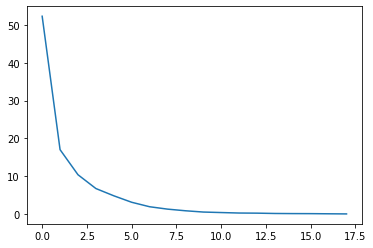

In [52]:
# Percentage of variance explained by principal components
plt.plot(var_exp)

In [53]:
cum_var_exp = np.cumsum(var_exp)
print("Cumulative Variance Explained:", cum_var_exp)

Cumulative Variance Explained: [ 52.35692143  69.37516502  79.75503849  86.48013163  91.28391272
  94.37063116  96.27266307  97.54386417  98.38040458  98.87744905
  99.2410236   99.47748448  99.6806391   99.79939497  99.88741418
  99.96183828  99.99797858 100.        ]


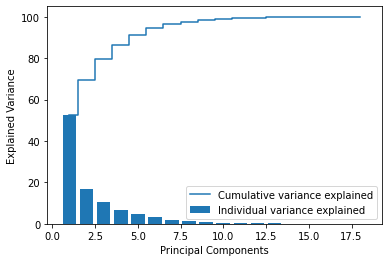

In [54]:
plt.bar(range(1, eig_vals.size+1), var_exp, align = 'center', label="Individual variance explained")
plt.step(range(1, eig_vals.size+1), cum_var_exp, where = 'mid', label="Cumulative variance explained")
plt.ylabel('Explained Variance')
plt.xlabel('Principal Components')
plt.legend(loc='best')
plt.show()

* 95% of the variance is explained by first 7 components

In [55]:
from sklearn.decomposition import PCA

In [56]:
pca = PCA(n_components=7) # for 95% variance
X_train_reduced = pca.fit_transform(X_train_pca)
#train_reduced.transpose()
print(X_train_reduced.shape)
X_test_reduced = pca.transform(X_test_pca)
print(X_test_reduced.shape)

(676, 7)
(170, 7)


In [57]:
pca.components_

array([[ 0.2757038 ,  0.29473806,  0.30359153,  0.26589519,  0.07992175,
         0.10852226,  0.31670852, -0.3133034 ,  0.31379088,  0.28237492,
         0.30936835,  0.31398382,  0.2726244 , -0.0129394 ,  0.04911378,
         0.05742357,  0.02384425,  0.06600264],
       [-0.13053682,  0.12885763, -0.07558308, -0.19536943, -0.13395839,
        -0.0240138 ,  0.04649693,  0.01396825,  0.0606656 ,  0.11278459,
         0.05677513,  0.05134277,  0.20837451,  0.48369938, -0.05223579,
        -0.14420402, -0.53571587, -0.53984736],
       [-0.1219695 , -0.02575636, -0.05551253,  0.27564941,  0.64529651,
         0.58017485, -0.0986184 ,  0.06138374, -0.11012194, -0.00724389,
         0.05028987, -0.11080634, -0.03366202,  0.28969166, -0.14271929,
        -0.07558786, -0.01970294,  0.01950552],
       [ 0.08264278,  0.18085162, -0.06893503, -0.04353778,  0.04332758,
         0.0549803 , -0.09939023,  0.09268963, -0.09317485,  0.18490026,
        -0.12083595, -0.09447042,  0.18673701, -0.062

In [58]:
df_pca_comp = pd.DataFrame(X_train_reduced, columns=['PC1','PC2','PC3','PC4','PC5','PC6','PC7'])
df_pca_comp.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7
0 -2.154964  2.281168  0.810625 -0.067678 -1.281030  0.157410 -0.398281
1 -1.770250  0.725225 -0.393261  1.279009  1.664692  0.676267 -0.629533
2 -4.985313  2.421471 -0.262843 -0.283273  1.136589  0.484020 -0.154424
3 -1.512321 -1.071753  1.572434 -0.179977 -0.974171  1.057694 -0.584121
4  6.864628  3.711374 -2.191996 -0.289644  0.118869  1.039169  0.626099

In [59]:
df_pca_comp.shape

(676, 7)

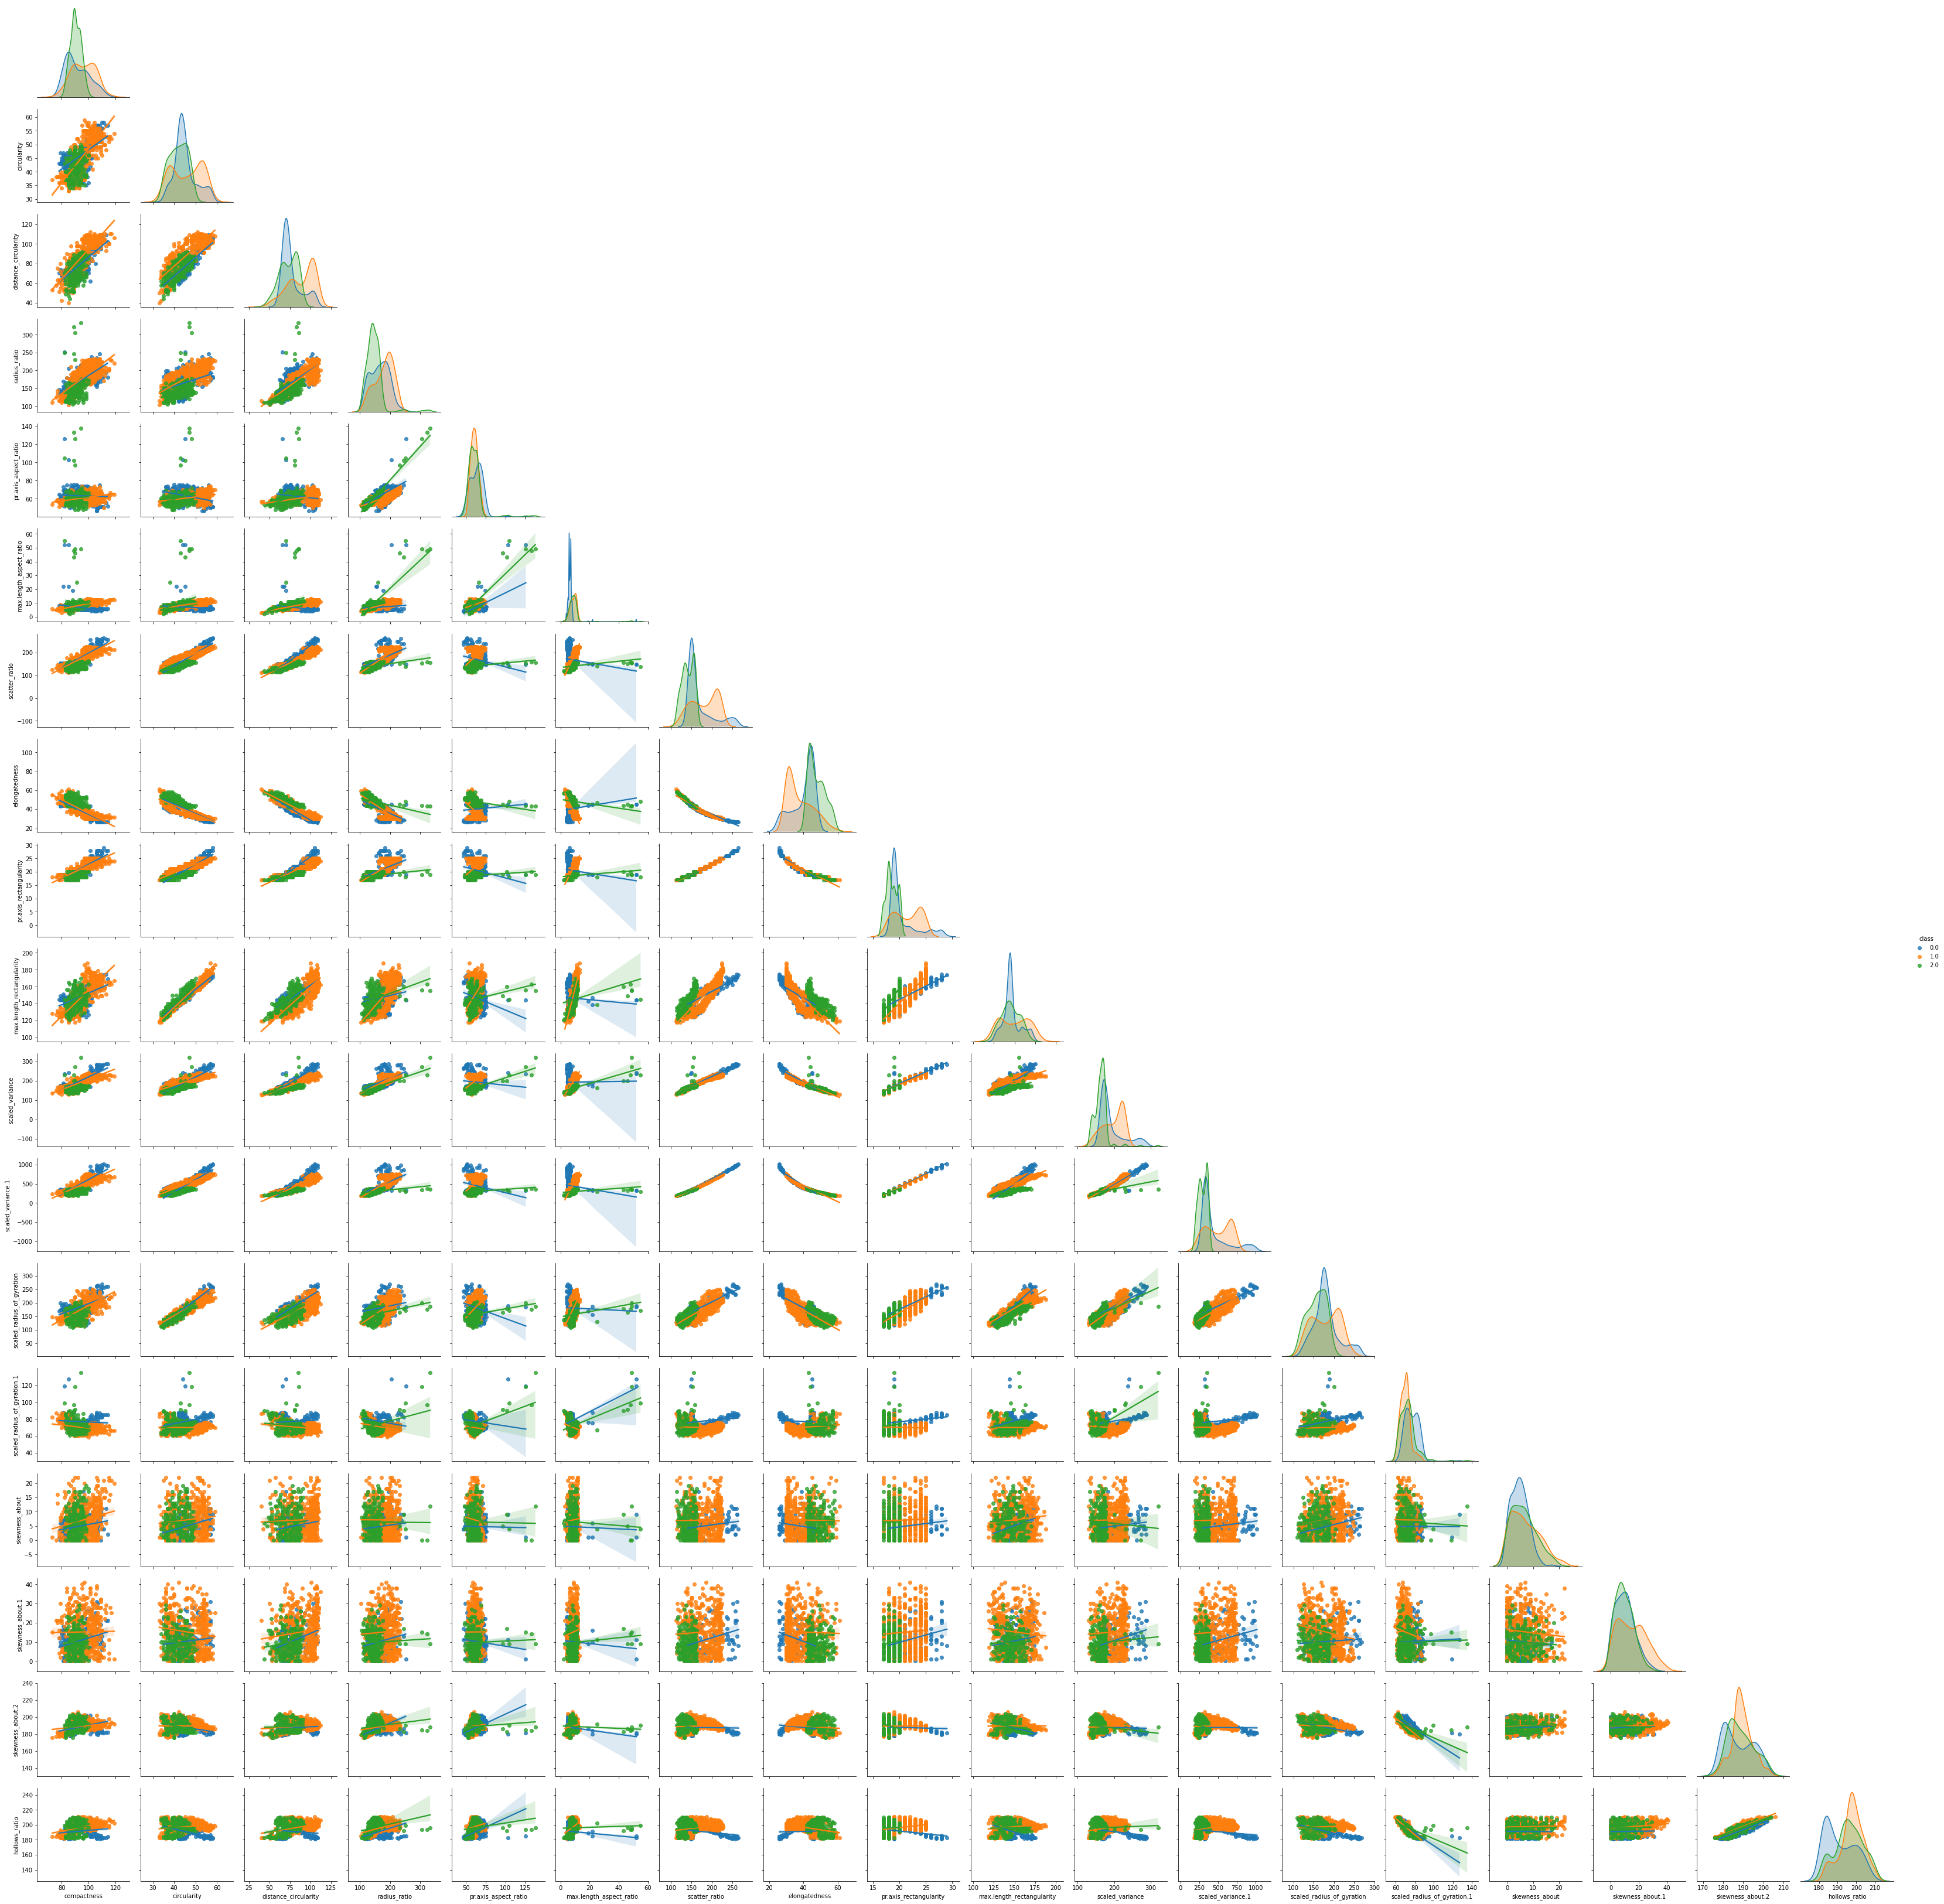

In [60]:
sns.pairplot(df_pca, kind='reg', corner=True, hue='class')

* Collinearity of attributes has been reduced which can be observed from the regression lines. 

In [61]:
# Using Grid search to find best parameters for SVM model
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
model=SVC()

In [62]:
params_pca = [{'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['linear']},
              {'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf'], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}]
grid_svm = GridSearchCV(model, param_grid = params_pca, scoring = 'accuracy', cv = 5)

In [63]:
grid_svm.fit(X_train_reduced, y_train_pca)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['linear']},
                         {'C': [0.001, 0.01, 0.1, 1, 10],
                          'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
                          'kernel': ['rbf']}],
             scoring='accuracy')

In [64]:
grid_svm.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

In [65]:
# Using best parameters for SVM
svc3 = SVC(C=100, kernel='rbf', gamma=0.01)
svc3.fit(X_train_reduced, y_train_pca)

SVC(C=100, gamma=0.01)

In [66]:
svc3_pred = svc3.predict(X_test_reduced)

In [67]:
# check the accuracy on the training set
print('Training accuracy:', svc3.score(X_train_reduced, y_train_pca))
print('Test accuracy:', svc3.score(X_test_reduced, y_test_pca))

Training accuracy: 0.9541420118343196
Test accuracy: 0.9235294117647059


In [68]:
svm3_acc = svc3.score(X_test_reduced, y_test_pca)
#kernel_accuracies.append(svm3_acc)
accuracies['SVM_3'] = svm3_acc

#### Model Comparision 

Text(0, 0.5, 'Accuracy scores')

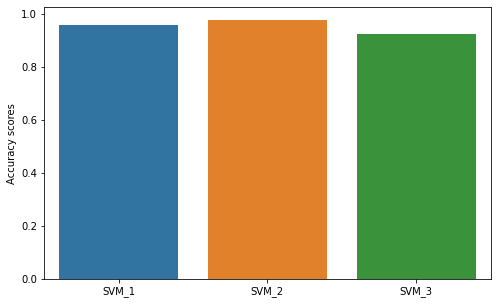

In [69]:
plt.figure(figsize = (8,5))
#plt.yticks(np.arange(0,100,10))
sns.barplot(x = list(accuracies.keys()), y = list(accuracies.values()))
plt.ylabel('Accuracy scores')

* SVM using attributes selected before and using best parameters from GridSearch gives the best accuracy scores on the test dataset.
* The performance is slightly compromised by using SVM on PCA components,however, we have reduced the dimensions of data from 18 to 7.

##### Confusion matrices

In [70]:
y_cm_svm1 = svc.predict(X_test) # svm
y_cm_svm2 = svc2.predict(X_test) # svm with GridSearch
y_cm_svm3 = svc3.predict(X_test_reduced) # svm after pca

In [71]:
from sklearn.metrics import confusion_matrix, classification_report

cm_svm1 = confusion_matrix(y_test, y_cm_svm1)
cm_svm2 = confusion_matrix(y_test, y_cm_svm2)
cm_svm3 = confusion_matrix(y_test_pca, y_cm_svm3)

Text(0.5, 15.0, 'Predicted label')

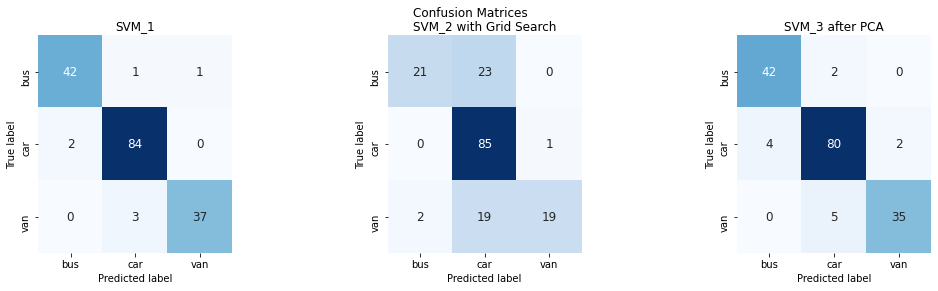

In [72]:
plt.figure(figsize = (16,4))
plt.suptitle("Confusion Matrices",fontsize=12)
plt.subplots_adjust(wspace = 0.8, hspace = 0.8)

plt.subplot(1,3,1)
plt.title("SVM_1")
sns.heatmap(cm_svm1, annot = True, cmap = "Blues", fmt = 'd', cbar = False, annot_kws = {"size": 12}, xticklabels = ['bus', 'car','van'], yticklabels = ['bus', 'car','van'])
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.subplot(1,3,2)
plt.title("SVM_2 with Grid Search")
sns.heatmap(cm_svm2, annot = True, cmap = "Blues", fmt = 'd', cbar = False, annot_kws = {"size": 12}, xticklabels = ['bus', 'car','van'], yticklabels = ['bus', 'car','van'])
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.subplot(1,3,3)
plt.title("SVM_3 after PCA")
sns.heatmap(cm_svm3, annot = True, cmap = "Blues", fmt = 'd', cbar = False, annot_kws = {"size": 12}, xticklabels = ['bus', 'car','van'], yticklabels = ['bus', 'car','van'])
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [73]:
print(classification_report(y_test, svc.predict(X_test))) # SVM before PCA

              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95        44
         1.0       0.95      0.98      0.97        86
         2.0       0.97      0.93      0.95        40

    accuracy                           0.96       170
   macro avg       0.96      0.95      0.96       170
weighted avg       0.96      0.96      0.96       170



In [74]:
print(classification_report(y_test, svc2.predict(X_test))) # SVM after tuning 

              precision    recall  f1-score   support

         0.0       0.91      0.48      0.63        44
         1.0       0.67      0.99      0.80        86
         2.0       0.95      0.47      0.63        40

    accuracy                           0.74       170
   macro avg       0.84      0.65      0.69       170
weighted avg       0.80      0.74      0.72       170



In [75]:
print(classification_report(y_test_pca, svc3.predict(X_test_reduced))) # SVM after PCA

              precision    recall  f1-score   support

         0.0       0.91      0.95      0.93        44
         1.0       0.92      0.93      0.92        86
         2.0       0.95      0.88      0.91        40

    accuracy                           0.92       170
   macro avg       0.93      0.92      0.92       170
weighted avg       0.92      0.92      0.92       170



* SVM model gives the best accuracy scores as well as the best classifications as observed in the confusion matrix.
* SVM model on PCA has around similar performance on reduced number of dimensions